# Simple Linear Classifier

An example of simple linear classifier (similar but not equivalent to a SVM). This however does **not** use support vectors, but instead uses a simple formulation and training over iteratively over batches.

Reference Links: 
- https://en.wikipedia.org/wiki/Support-vector_machine
- https://pytorch.org/docs/stable/generated/torch.nn.SoftMarginLoss.html

In [1]:
from itertools import cycle
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [2]:
DEVICE = "cpu"

## Data Generation

In [3]:
# data gen
X = np.random.normal(0, 1, (1_000, 2))
X = X.astype(np.float32)

# define our seperator (y = mx + b)
m, b = 2, -1.2

# do target classes
class_bool = X[:, 1] < m*X[:, 0] + b + np.random.normal(0, 0.5, (1000,))
y = -1.*class_bool + 1.*np.logical_not(class_bool)  # definition comes from SoftMarginLoss requirement
y = y.astype(np.float32)

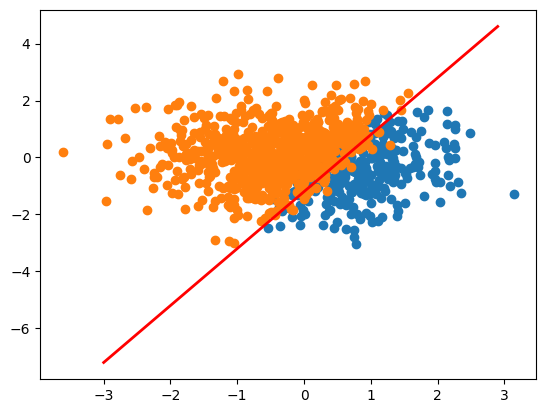

In [4]:
# visualize data
plt.scatter(X[class_bool, 0], X[class_bool, 1])
plt.scatter(X[np.logical_not(class_bool), 0], X[np.logical_not(class_bool), 1])
plt.plot(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1)*m + b, linewidth=2, color="red")

## Module Definition

In [5]:
class LinearClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.m = torch.nn.Parameter(torch.from_numpy(np.array([0.], dtype=np.float32)), requires_grad=True)
        self.b = torch.nn.Parameter(torch.from_numpy(np.array([0.], dtype=np.float32)), requires_grad=True)
    
    def forward_train(self, X):
        probs = torch.softmax(
            torch.stack([X[:, 0] * self.m + self.b, X[:, 1]], dim=1),
            dim=1
        )
        return -1.*probs[:,0] + 1.*probs[:,1]

    def forward_test(self, X):
        if isinstance(X, np.ndarray):
            X = torch.from_numpy(X)
        class_bool = X[:, 1] < X[:, 0] * self.m + self.b
        return -1.*class_bool + 1.*torch.logical_not(class_bool)
    
    def __repr__(self):
        return f"{self.m}, {self.b}"


## Dataset Definition

In [6]:
class NumpyRepeatDataset(torch.utils.data.IterableDataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
    
    def __iter__(self):
        self._iter_X = iter(cycle(self.X))
        self._iter_y = iter(cycle(self.y))
        return self

    def __next__(self):
        return next(self._iter_X), next(self._iter_y)

## Training Setup

In [7]:
lc = LinearClassifier()
optim = torch.optim.SGD(lc.parameters(), lr=0.1)
loss_fn = torch.nn.SoftMarginLoss()

train_dataset = NumpyRepeatDataset(X, y)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 20,
)
iter_train_dataloader = iter(train_dataloader)

## Training Loop

In [8]:
total_steps = 10_000
loss_steps = set([i for i in range(total_steps//10, total_steps+1, total_steps//10)])
viz_steps = set([1, 10, 50, 100, 200])
viz_steps = set([])

lc.to(DEVICE)

import time
start_time = time.perf_counter()

for i in range(total_steps):
    optim.zero_grad()
    t_X, t_y = next(iter_train_dataloader)
    t_X = t_X.to(DEVICE)
    t_y = t_y.to(DEVICE)
    output = lc.forward_train(t_X)
    loss = loss_fn(output, t_y)
    
    if i in loss_steps:
        print(f"loss @ {i}th step: {loss} in {time.perf_counter() - start_time}s")
        start_time = time.perf_counter()
        
    if i in viz_steps:
        plt.scatter(X[class_bool, 0], X[class_bool, 1])
        plt.scatter(X[np.logical_not(class_bool), 0], X[np.logical_not(class_bool), 1])
        plt.plot(
            np.arange(-3, 3, 0.1), 
            np.arange(-3, 3, 0.1)*lc.m.detach().cpu().numpy() + lc.b.detach().cpu().numpy(), 
            linewidth=2, color="red"
        )
        plt.gca().set_title(f"{i}th step")
        plt.show()
    
    loss.backward()
    optim.step()

loss @ 1000th step: 0.4389261305332184 in 0.2971201279997331s
loss @ 2000th step: 0.42454904317855835 in 0.26801354700000957s
loss @ 3000th step: 0.4186091423034668 in 0.26818724600025234s
loss @ 4000th step: 0.4152284264564514 in 0.2668075250003312s
loss @ 5000th step: 0.41300278902053833 in 0.2650969940000323s
loss @ 6000th step: 0.4114096760749817 in 0.2674285990001408s
loss @ 7000th step: 0.4102053642272949 in 0.2681142589999581s
loss @ 8000th step: 0.40925949811935425 in 0.2685699300000124s
loss @ 9000th step: 0.40849557518959045 in 0.2678145680001762s


## Testing Results

In [9]:
lc.to("cpu")
print(classification_report(
    y,
    lc.forward_test(X).numpy())
)

              precision    recall  f1-score   support

        -1.0       0.89      0.79      0.84       278
         1.0       0.92      0.96      0.94       722

    accuracy                           0.91      1000
   macro avg       0.91      0.88      0.89      1000
weighted avg       0.91      0.91      0.91      1000



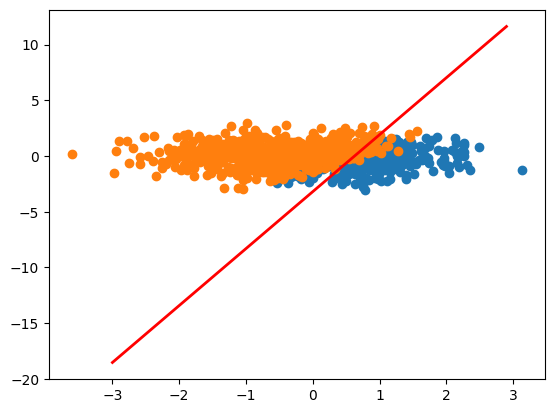

In [10]:
# visualize data
plt.scatter(X[class_bool, 0], X[class_bool, 1])
plt.scatter(X[np.logical_not(class_bool), 0], X[np.logical_not(class_bool), 1])
plt.plot(
    np.arange(-3, 3, 0.1), 
    np.arange(-3, 3, 0.1)*lc.m.detach().cpu().numpy() + lc.b.detach().cpu().numpy(), 
    linewidth=2, color="red"
)